In [1]:
import sys
sys.path.append("..")

import pickle
import re
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style = "whitegrid")

from matplotlib import pyplot as plt

from utils.youtube import extractTranscriptsFromVideoID
from utils.splitter import WebVTTTextSplitter 

from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain import PromptTemplate 
from langchain.chains import LLMChain
from langchain.llms import OpenAI

from datetime import datetime, timedelta

from dotenv import load_dotenv
load_dotenv("../.env")

True

In [2]:
DATA_DIR = f"../data/experiments"
DATA_PATH = f"{DATA_DIR}/finalDataset.csv"

In [3]:
pickle.load(open(f"{DATA_DIR}/chapters_sample.pkl", "rb"))

,videoID,startTimestamp,endTimestamp,chapterDuration,chapterTitle,chapterTranscripts,chapterTranscriptDocument,totalChapterTranscriptDocuments,questionsAndJustifications
2035,ZXdFisA_hOY,0 days 00:00:00,0 days 00:03:02,0 days 00:03:02,Introduction,WEBVTT\n\n00:00:00.089 --> 00:00:05.350\nYou a...,"[page_content=""You are about to learn how to u...",2,"[[{'question': 'What is a REST API?', 'justifi..."
2036,ZXdFisA_hOY,0 days 00:03:02,0 days 00:04:01,0 days 00:00:59,Creating the project,WEBVTT\n\n00:03:02.310 --> 00:03:06.049\nSo he...,"[page_content=""So here we are in business to r...",1,[[{'question': 'What kind of terminal are we u...
2037,ZXdFisA_hOY,0 days 00:04:01,0 days 00:10:03,0 days 00:06:02,Exploring the generated project files,WEBVTT\n\n00:03:59.180 --> 00:04:03.459\ncan a...,"[page_content=""can actually see all the genera...",3,[[{'question': 'What is the purpose of the ACS...
2038,ZXdFisA_hOY,0 days 00:10:03,0 days 00:11:36,0 days 00:01:33,Trusting the selfsigned certificate,WEBVTT\n\n00:10:00.790 --> 00:10:06.590\nHear ...,"[page_content=""Hear me expand this a little bi...",1,[[{'question': 'What is the purpose of the dot...
2039,ZXdFisA_hOY,0 days 00:11:36,0 days 00:12:30,0 days 00:00:54,Exploring the default Swagger UI page,WEBVTT\n\n00:11:33.790 --> 00:11:38.980\nseein...,"[page_content=""seeing any trust issue anymore....",1,"[[{'question': 'What is swagger?', 'justificat..."
...,...,...,...,...,...,...,...,...,...
2134,ZXdFisA_hOY,0 days 05:57:51,0 days 05:59:40,0 days 00:01:49,Testing DeleteItemAsync,WEBVTT\n\n05:57:42.260 --> 05:57:52.500\nthe c...,"[page_content=""the content result. So let's go...",1,[[{'question': 'What is the purpose of the vid...
2135,ZXdFisA_hOY,0 days 05:59:40,0 days 06:10:50,0 days 00:11:10,Refactoring and catching regressions,WEBVTT\n\n05:59:37.290 --> 05:59:44.718\npassi...,"[page_content=""passing at this point. Okay, so...",4,[[{'question': 'What changes are being made to...
2136,ZXdFisA_hOY,0 days 06:10:50,0 days 06:19:07,0 days 00:08:17,Using TDD to test a yet to be created method,WEBVTT\n\n06:10:49.250 --> 06:10:55.760\ngreen...,"[page_content=""green. Okay, so that's working ...",3,[[{'question': 'What is the method that return...
2137,ZXdFisA_hOY,0 days 06:19:07,0 days 06:21:19,0 days 00:02:12,Going back to green by fixing the failing test,WEBVTT\n\n06:19:05.548 --> 06:19:11.148\nhere....,"[page_content=""here. So let's see how we can f...",1,[[{'question': 'What are the steps used to fix...


# **Loading Data**

In [4]:
df = pd.read_csv(DATA_PATH).drop("Unnamed: 0", axis = 1).dropna()
df["startTimestamp"] = df["startTimestamp"].apply(lambda timestamp: re.findall(r"(\d+:\d+:\d+)", timestamp)[0])
df["startTimestamp"] = df["startTimestamp"].apply(lambda dt: datetime.strptime(dt, "%H:%M:%S"))
df["startTimestamp"] = df["startTimestamp"].apply(lambda dt: timedelta(hours = dt.hour, minutes = dt.minute, seconds = dt.second))
df["endTimestamp"] = df["endTimestamp"].apply(lambda timestamp: re.findall(r"(\d+:\d+:\d+)", timestamp)[0])
df["endTimestamp"] = df["endTimestamp"].apply(lambda dt: datetime.strptime(dt, "%H:%M:%S"))
df["endTimestamp"] = df["endTimestamp"].apply(lambda dt: timedelta(hours = dt.hour, minutes = dt.minute, seconds = dt.second))
print(df.shape[0])
df.head(3)

854


,videoID,startTimestamp,endTimestamp,question,justification
0,ZXdFisA_hOY,0 days,0 days 00:03:02,What is a REST API?,This question can be answered based on the giv...
1,ZXdFisA_hOY,0 days,0 days 00:03:02,What is .NET 5?,This question can be answered based on the giv...
2,ZXdFisA_hOY,0 days,0 days 00:03:02,What do I need to follow the tutorial?,This question can be answered based on the giv...


# **Ground Truth Dataset Characterization**

In [5]:
datasetStatisticsDF = df.groupby(["videoID", "startTimestamp", "endTimestamp"]).agg(
    lambda group: list(group)
).reset_index()
datasetStatisticsDF["totalChapters"] = 1
datasetStatisticsDF["chapterLength"] = datasetStatisticsDF["endTimestamp"] - datasetStatisticsDF["startTimestamp"]
datasetStatisticsDF["totalChapterQuestions"] = datasetStatisticsDF["question"].apply(len)
datasetStatisticsDF = datasetStatisticsDF[["videoID", "totalChapters", "chapterLength", "totalChapterQuestions"]]
datasetStatisticsDF = datasetStatisticsDF.groupby("videoID").agg({
    "totalChapters": "count",
    "chapterLength": ["mean", "std", "min", "median", "max"],
    "totalChapterQuestions": ["mean", "std", "min", "median", "max", "sum"],
})
datasetStatisticsDF.columns = ["_".join(column) for column in datasetStatisticsDF.columns]
datasetStatisticsDF = pd.concat(
    [df.set_index("videoID").loc[datasetStatisticsDF.index].reset_index()[["videoID", "endTimestamp"]].groupby("videoID").max(), datasetStatisticsDF]
    , axis = 1
)
datasetStatisticsDF.columns = [
    "length", "totalChapters", "chapterLengthMean", "chapterLengthStd", "chapterLengthMin",
    "chapterLengthMedian", "chapterLengthMax", "totalChapterQuestionsMean", "totalChapterQuestionsStd", 
    "totalChapterQuestionsMin", "totalChapterQuestionsMedian", "totalChapterQuestionsMax", "totalQuestions"
]
datasetStatisticsDF

,length,totalChapters,chapterLengthMean,chapterLengthStd,chapterLengthMin,chapterLengthMedian,chapterLengthMax,totalChapterQuestionsMean,totalChapterQuestionsStd,totalChapterQuestionsMin,totalChapterQuestionsMedian,totalChapterQuestionsMax,totalQuestions
videoID,,,,,,,,,,,,,
ZXdFisA_hOY,0 days 06:24:09,103,0 days 00:03:42.417475728,0 days 00:02:25.390921600,0 days 00:00:29,0 days 00:03:09,0 days 00:11:10,8.291262,4.253329,3,8.0,22,854


# **Experiments**

In [6]:
# Uncomment the lines below to extract embeddings again
# videoData = {}
# for videoID in df.videoID.unique():
#     transcripts, transcriptsType = extractTranscriptsFromVideoID(videoID)
#     videoData[videoID] = {"transcripts": transcripts}

# embeddings = OpenAIEmbeddings(model = "text-embedding-ada-002")
# splitter = WebVTTTextSplitter(chunk_size = 60, chunk_overlap = 10)
# for videoID in videoData.keys():
#     transcripts = videoData[videoID]["transcripts"]
#     documents = splitter.create_documents([transcripts], metadatas = [{"videoID": videoID}])
#     videoData[videoID]["documents"] = documents
#     videoData[videoID]["vectorstore"] = FAISS.from_documents(documents, embedding = embeddings)
#     videoData[videoID]["retriever"] = videoData[videoID]["vectorstore"].as_retriever()
# videoData = pd.DataFrame(videoData.values(), index = videoData.keys())

# with open(f"{DATA_DIR}/experimentVideoData.pkl", "wb") as f:
#     pickle.dump(videoData, f)

videoData = pickle.load(open(f"{DATA_DIR}/experimentVideoData.pkl", "rb"))
videoData

,transcripts,documents,vectorstore,retriever
ZXdFisA_hOY,WEBVTT\n\n00:00:00.089 --> 00:00:05.350\nYou a...,"[page_content=""You are about to learn how to u...",<langchain.vectorstores.faiss.FAISS object at ...,vectorstore=<langchain.vectorstores.faiss.FAIS...


## **Experiment Dataset Characterization**

In [314]:
experimentDataset = videoData[["documents"]].copy(deep = True)
experimentDataset["totalDocuments"] = experimentDataset.documents.apply(len)
experimentDataset["segmentLength"] = experimentDataset.documents.apply(lambda documents: [
    (document.metadata["startTimestamp"], document.metadata["endTimestamp"]) for document in documents
])
experimentDataset

,documents,totalDocuments,segmentLength
ZXdFisA_hOY,"[page_content=""You are about to learn how to u...",458,"[(00:00:00.089, 00:00:58.470), (00:00:53.920, ..."


## **Evaluation Metric**

In [4]:
def R_at_n_IoU_m(
    df, 
    indexColumn, 
    groundTruthStartColumn, 
    groundTruthEndColumn, 
    retrievedStartColumn, 
    retrievedEndColumn, 
    rankColumn,
    n = 4, 
    m = 10 # in seconds
):
    """A.k.a. "R@n, IoU = m". This metric is commonly used as evaluation metric to measure performances of moment localization. See Section 6.2 from the following survey: https://web.archive.org/web/20220821013114id_/https://dl.acm.org/doi/pdf/10.1145/3556537"""
    df = df[df[rankColumn] <= n].copy(deep = True)

    df["intersectionStartTimestamp"] = df.apply(
        lambda row: max(row[groundTruthStartColumn], row[retrievedStartColumn]), 
        axis = 1
    )

    df["intersectionEndTimestamp"] = df.apply(
        lambda row: min(row[groundTruthEndColumn], row[retrievedEndColumn]), 
        axis = 1
    )

    df["intersectionLength"] = df.apply(
        lambda row: row["intersectionEndTimestamp"] - row["intersectionStartTimestamp"], 
        axis = 1
    )

    df["intersectionLength"] = df["intersectionLength"].apply(
        lambda length: timedelta(seconds = 0) if length < timedelta(seconds = 0) else length
    )
    
    df["intersectionLenghtLargerThanM"] = df["intersectionLength"].apply(lambda length: length >= timedelta(seconds = m))
    
    score = df[[indexColumn, "intersectionLenghtLargerThanM"]].groupby([indexColumn]).agg(any).mean()
    score = score.intersectionLenghtLargerThanM
    
    return score

# **Segment Retrieval + LLM**

In [12]:
QA_TEMPLATE = """You are an advanced chatbot equipped to assist users in extracting valuable information from video transcripts. Your primary objective is to provide accurate answers based on the available context, timestamps, and user input. When generating your response, you don't need to consider the entire context. Just focus on a subset with the most relevant context to answer the question. You can also use your general knowledge to complement the answers, but if you are uncertain about how to answer, just say that you don't know how to answer. Use the following format to provide your answer:
- Based on video clip from <start timestamp 1> to <end timestamp 1>: <your answer>.
- Based on video clip from <start timestamp 2> to <end timestamp 2>: <your answer>.
...
- Based on video clip from <start timestamp n> to <end timestamp n>: <your answer>.

Transcripts: {context}

User's input: {query}

Answer: """

qaPrompt = PromptTemplate(template = QA_TEMPLATE, input_variables = ["context", "query"])

bot = LLMChain(
    prompt = qaPrompt,
    llm = OpenAI(model_name = "text-davinci-003", temperature = 0.1)
)

In [5]:
def timestampStringToTimedelta(timestamp, format = "%H:%M:%S.%f"):
    dt = datetime.strptime(timestamp, format)
    return timedelta(hours = dt.hour, minutes = dt.minute, seconds = dt.second)

In [6]:
# Uncomment the lines below if you need to get relevant documents and generate the answers for questions again
# df["relevantDocuments"] = df.apply(lambda row: videoData.loc[row["videoID"]]["retriever"].get_relevant_documents(row["question"]), axis = 1)
# df["llmAnswer"] = df.apply(lambda row: bot.run(
#     context = "\n\n".join([f"{doc.metadata['startTimestamp']} --> {doc.metadata['endTimestamp']}\n{doc.page_content}" for doc in row.relevantDocuments]),
#     query = row.question
# ).strip(), axis = 1)

# df["relevantDocumentsTimestamps"] = df.relevantDocuments.apply(
#     lambda documents: [(
#         timestampStringToTimedelta(doc.metadata["startTimestamp"]), 
#         timestampStringToTimedelta(doc.metadata["endTimestamp"]),
#         rank
#     ) for rank, doc in enumerate(documents, start = 1)]
# )
# df["llmAnswerTimestamps"] = df.llmAnswer.apply(
#     lambda answer: [(
#         timestampStringToTimedelta(timestamp[0]),
#         timestampStringToTimedelta(timestamp[1]),
#         rank
#     ) for rank, timestamp in enumerate(re.findall(r"from ([\d\:\.]+) (?:to|-->) ([\d\:\.]+):.*", answer))]
# )

# df.to_csv(f"{DATA_DIR}/finalDataset_exp_results.csv", index = False, lineterminator = "\n")
# with open(f"{DATA_DIR}/finalDataset_exp_results.pkl", "wb") as f:
#     pickle.dump(df, f)

# df = pd.read_csv(f"{DATA_DIR}/finalDataset_exp_results.csv", lineterminator="\n")
df = pickle.load(open(f"{DATA_DIR}/finalDataset_exp_results.pkl", "rb"))

df["questionID"] = df.index + 1

print(df.shape[0])
df.head(3)

854


,videoID,startTimestamp,endTimestamp,question,justification,relevantDocuments,llmAnswer,relevantDocumentsTimestamps,llmAnswerTimestamps,questionID
0,ZXdFisA_hOY,0 days,0 days 00:03:02,What is a REST API?,This question can be answered based on the giv...,"[page_content=""So as we know, we do have a RES...",Based on video clip from 00:00:00.089 to 00:00...,"[(2:40:01, 2:40:59, 1), (0:00:00, 0:00:58, 2),...","[(0:00:00, 0:00:58, 0)]",1
1,ZXdFisA_hOY,0 days,0 days 00:03:02,What is .NET 5?,This question can be answered based on the giv...,"[page_content=""You are about to learn how to u...",Based on video clip from 00:00:00.089 to 00:00...,"[(0:00:00, 0:00:58, 1), (3:22:49, 3:23:47, 2),...","[(0:00:00, 0:00:58, 0)]",2
2,ZXdFisA_hOY,0 days,0 days 00:03:02,What do I need to follow the tutorial?,This question can be answered based on the giv...,"[page_content=""how to use Visual Studio code f...",- Based on video clip from 00:00:53.920 to 00:...,"[(0:00:53, 0:01:52, 1), (0:14:08, 0:15:06, 2),...","[(0:00:53, 0:01:52, 0), (0:14:08, 0:15:06, 1),...",3


In [16]:
df.llmAnswer.iloc[1]

'Based on video clip from 00:00:00.089 to 00:00:58.470: .NET 5 is a platform for creating a Rest API that allows your app or system to expose its functionality to multiple types of clients both inside and outside of your network, including clients across the internet.'

## **Only Segment Retrieval**

In [14]:
onlySegmentRetrievalDF = df.copy(deep = True)[["questionID", "startTimestamp", "endTimestamp", "relevantDocumentsTimestamps"]]
onlySegmentRetrievalDF = onlySegmentRetrievalDF.explode("relevantDocumentsTimestamps")
onlySegmentRetrievalDF.head(3)
onlySegmentRetrievalDF = pd.concat([
    onlySegmentRetrievalDF.drop("relevantDocumentsTimestamps", axis = 1), 
    onlySegmentRetrievalDF.relevantDocumentsTimestamps.apply(pd.Series)
], axis = 1)
onlySegmentRetrievalDF.columns = ["questionID", "startTimestamp", "endTimestamp", "retrievedStartTimestamp", "retrievedEndTimestamp", "rank"]
onlySegmentRetrievalDF

,questionID,startTimestamp,endTimestamp,retrievedStartTimestamp,retrievedEndTimestamp,rank
0,1,0 days 00:00:00,0 days 00:03:02,0 days 02:40:01,0 days 02:40:59,1
0,1,0 days 00:00:00,0 days 00:03:02,0 days 00:00:00,0 days 00:00:58,2
0,1,0 days 00:00:00,0 days 00:03:02,0 days 03:01:39,0 days 03:02:37,3
0,1,0 days 00:00:00,0 days 00:03:02,0 days 02:40:53,0 days 02:41:46,4
1,2,0 days 00:00:00,0 days 00:03:02,0 days 00:00:00,0 days 00:00:58,1
...,...,...,...,...,...,...
852,853,0 days 06:21:19,0 days 06:24:09,0 days 02:24:54,0 days 02:25:51,4
853,854,0 days 06:21:19,0 days 06:24:09,0 days 01:55:31,0 days 01:56:26,1
853,854,0 days 06:21:19,0 days 06:24:09,0 days 06:19:11,0 days 06:20:04,2
853,854,0 days 06:21:19,0 days 06:24:09,0 days 06:20:04,0 days 06:21:02,3


In [184]:
onlySegmentRetrievalPlotData = []
onlySegmentRetrievalPlotColumns = ["R@n, IoU = m", "n", "m"]

for n in range(1,5):
    for m in range(1, 61):
        score = R_at_n_IoU_m(
            onlySegmentRetrievalDF, 
            "questionID", 
            "startTimestamp", 
            "endTimestamp", 
            "retrievedStartTimestamp", 
            "retrievedEndTimestamp", 
            "rank",
            n = n,
            m = m
        )
        onlySegmentRetrievalPlotData.append([score, n, m])

onlySegmentRetrievalPlotDF = pd.DataFrame(data = onlySegmentRetrievalPlotData, columns = onlySegmentRetrievalPlotColumns)
print(onlySegmentRetrievalPlotDF.shape[0])
onlySegmentRetrievalPlotDF.head()

240


,"R@n, IoU = m",n,m
0,0.528103,1,1
1,0.528103,1,2
2,0.526932,1,3
3,0.526932,1,4
4,0.522248,1,5


/tmp/ipykernel_22046/4019663718.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(data = onlySegmentRetrievalPlotDF, x = "m", y = "R@n, IoU = m", hue = "n", palette = sns.color_palette("tab10"))


Text(0.5, 0, 'm (sec)')

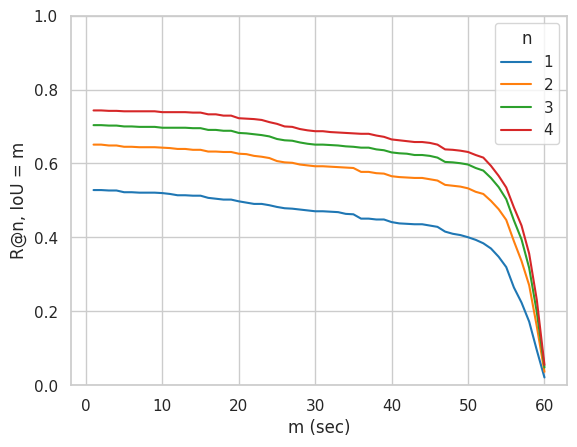

In [208]:
sns.lineplot(data = onlySegmentRetrievalPlotDF, x = "m", y = "R@n, IoU = m", hue = "n", palette = sns.color_palette("tab10"))
plt.ylim([0,1])
plt.xlabel("m (sec)")

## **With LLM**

In [8]:
withLLMDF = df.copy(deep = True)[["questionID", "startTimestamp", "endTimestamp", "llmAnswerTimestamps"]]
withLLMDF = withLLMDF.explode("llmAnswerTimestamps")
withLLMDF.head(3)
withLLMDF = pd.concat([
    withLLMDF.drop("llmAnswerTimestamps", axis = 1), 
    withLLMDF.llmAnswerTimestamps.apply(pd.Series)
], axis = 1)
withLLMDF.columns = ["questionID", "startTimestamp", "endTimestamp", "retrievedStartTimestamp", "retrievedEndTimestamp", "rank"]
withLLMDF

,questionID,startTimestamp,endTimestamp,retrievedStartTimestamp,retrievedEndTimestamp,rank
0,1,0 days 00:00:00,0 days 00:03:02,0 days 00:00:00,0 days 00:00:58,0.0
1,2,0 days 00:00:00,0 days 00:03:02,0 days 00:00:00,0 days 00:00:58,0.0
2,3,0 days 00:00:00,0 days 00:03:02,0 days 00:00:53,0 days 00:01:52,0.0
2,3,0 days 00:00:00,0 days 00:03:02,0 days 00:14:08,0 days 00:15:06,1.0
2,3,0 days 00:00:00,0 days 00:03:02,0 days 03:21:06,0 days 03:22:05,2.0
...,...,...,...,...,...,...
851,852,0 days 06:21:19,0 days 06:24:09,0 days 06:08:34,0 days 06:09:33,1.0
851,852,0 days 06:21:19,0 days 06:24:09,0 days 06:22:33,0 days 06:23:31,2.0
851,852,0 days 06:21:19,0 days 06:24:09,0 days 01:03:34,0 days 01:04:33,3.0
852,853,0 days 06:21:19,0 days 06:24:09,0 days 05:55:54,0 days 05:56:48,0.0


In [67]:
index = 56
print(df[df["questionID"] == index].justification.iloc[0])
display(df[df["questionID"] == index])
withLLMDF[(withLLMDF["retrievedStartTimestamp"] - withLLMDF["endTimestamp"]) > timedelta(0)][12:30]

The transcripts mention a “price” property being added, and provide an explanation of its purpose.


,videoID,startTimestamp,endTimestamp,question,justification,relevantDocuments,llmAnswer,relevantDocumentsTimestamps,llmAnswerTimestamps,questionID
55,ZXdFisA_hOY,0 days 00:15:45,0 days 00:20:39,What is the purpose of the “price” property?,The transcripts mention a “price” property bei...,"[page_content=""description property price, and...",Based on video clip from 05:34:39.808 to 05:35...,"[(6:02:32, 6:03:31, 1), (6:06:44, 6:07:44, 2),...","[(5:34:39, 5:35:38, 0)]",56


,questionID,startTimestamp,endTimestamp,retrievedStartTimestamp,retrievedEndTimestamp,rank
12,13,0 days 00:03:02,0 days 00:04:01,0 days 00:04:15,0 days 00:05:11,0.0
12,13,0 days 00:03:02,0 days 00:04:01,0 days 05:05:17,0 days 05:06:13,1.0
12,13,0 days 00:03:02,0 days 00:04:01,0 days 05:08:37,0 days 05:09:34,2.0
15,16,0 days 00:04:01,0 days 00:10:03,0 days 05:08:37,0 days 05:09:34,1.0
24,25,0 days 00:04:01,0 days 00:10:03,0 days 00:13:22,0 days 00:14:17,0.0
24,25,0 days 00:04:01,0 days 00:10:03,0 days 03:27:59,0 days 03:28:54,1.0
25,26,0 days 00:04:01,0 days 00:10:03,0 days 04:56:49,0 days 04:59:18,0.0
27,28,0 days 00:04:01,0 days 00:10:03,0 days 04:58:20,0 days 04:59:18,0.0
27,28,0 days 00:04:01,0 days 00:10:03,0 days 05:00:04,0 days 05:01:04,1.0
27,28,0 days 00:04:01,0 days 00:10:03,0 days 05:00:55,0 days 05:01:54,2.0


In [9]:
withLLMPlotData = []
withLLMPlotColumns = ["R@n, IoU = m", "n", "m"]

for n in range(1,5):
    for m in range(1, 61):
        score = R_at_n_IoU_m(
            withLLMDF, 
            "questionID", 
            "startTimestamp", 
            "endTimestamp", 
            "retrievedStartTimestamp", 
            "retrievedEndTimestamp", 
            "rank",
            n = n,
            m = m
        )
        withLLMPlotData.append([score, n, m])

withLLMPlotDF = pd.DataFrame(data = withLLMPlotData, columns = withLLMPlotColumns)
print(withLLMPlotDF.shape[0])
withLLMPlotDF.head()

240


,"R@n, IoU = m",n,m
0,0.560517,1,1
1,0.560517,1,2
2,0.559342,1,3
3,0.559342,1,4
4,0.558167,1,5


/tmp/ipykernel_1240/3441840962.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(data = withLLMPlotDF, x = "m", y = "R@n, IoU = m", hue = "n", palette = sns.color_palette("tab10"))


Text(0.5, 0, 'm (sec)')

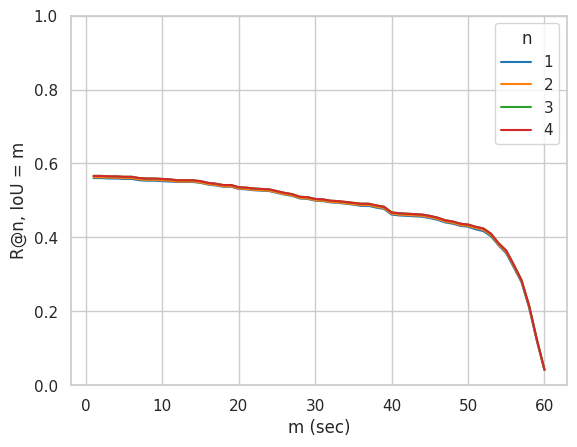

In [12]:
sns.lineplot(data = withLLMPlotDF, x = "m", y = "R@n, IoU = m", hue = "n", palette = sns.color_palette("tab10"))
plt.ylim([0,1])
plt.xlabel("m (sec)")

In [20]:
(withLLMDF["rank"] + 1).value_counts()

rank
1.0    851
2.0    203
3.0    115
4.0     60
Name: count, dtype: int64

In [333]:
# Example with complete intersection
exampleIndex = 15
print("\n\n".join(df[["question", "justification", "llmAnswer"]].loc[exampleIndex].values))
df.loc[[exampleIndex]]

What is the target framework for the project?

The target framework is stated in the transcripts, which is .NET five.

- Based on video clip from 00:04:15.209 to 00:05:11.699: The target framework for the project is .NET 5. 
- Based on video clip from 05:08:37.830 to 05:09:34.798: The preferred framework for this project is xUnit.


,videoID,startTimestamp,endTimestamp,question,justification,relevantDocuments,llmAnswer,relevantDocumentsTimestamps,llmAnswerTimestamps,questionID
15,ZXdFisA_hOY,0 days 00:04:01,0 days 00:10:03,What is the target framework for the project?,The target framework is stated in the transcri...,"[page_content=""how we're going to build this p...",- Based on video clip from 00:04:15.209 to 00:...,"[(0:04:15, 0:05:11, 1), (5:08:37, 5:09:34, 2),...","[(0:04:15, 0:05:11, 0), (5:08:37, 5:09:34, 1)]",16


In [332]:
# Example with partial intersection
exampleIndex = 14
print("\n\n".join(df[["question", "justification", "llmAnswer"]].loc[exampleIndex].values))
df.loc[[exampleIndex]]

What is the purpose of the ACS proc file?

The purpose of the ACS proc file is stated in the transcripts, which is to declare how the project will be built.

Based on video clip from 00:03:29.459 --> 00:04:24.430: The ACS proc file is used to declare how the project will be built, including the dotnet web SDK and other tools and tasks needed to build the container.


,videoID,startTimestamp,endTimestamp,question,justification,relevantDocuments,llmAnswer,relevantDocumentsTimestamps,llmAnswerTimestamps,questionID
14,ZXdFisA_hOY,0 days 00:04:01,0 days 00:10:03,What is the purpose of the ACS proc file?,The purpose of the ACS proc file is stated in ...,"[page_content=""is going to be catalog, hit Ent...",Based on video clip from 00:03:29.459 --> 00:0...,"[(0:03:29, 0:04:24, 1), (3:25:22, 3:26:20, 2),...","[(0:03:29, 0:04:24, 0)]",15
